In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

- 날짜는 그때그때 변경

In [2]:
date = '0604'

In [3]:
CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'IMG_SIZE':224,
    'EPOCHS':50,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':8,
    'SEED':1203
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### zip파일 압축 해제

In [5]:
import zipfile
import os

# ZIP 파일 경로와 추출 경로를 지정합니다.
zip_file_path = '/content/drive/MyDrive/image classification/open.zip'
extract_to_path = '/content/data'

# 추출 경로가 존재하지 않으면 생성합니다.
if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

# ZIP 파일을 열고 추출합니다.
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

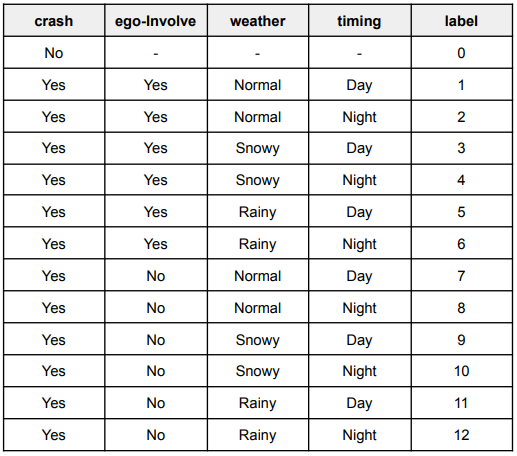

In [7]:
df = pd.read_csv('/content/data/train.csv')

df.loc[df['sample_id'].isin(['TRAIN_2236', 'TRAIN_2596']), 'label'] = 0
df.loc[df['sample_id'].isin(['TRAIN_0061', 'TRAIN_0107', 'TRAIN_0123', 'TRAIN_0294',
    'TRAIN_0800', 'TRAIN_1280', 'TRAIN_1590', 'TRAIN_2302', 'TRAIN_2548']), 'label'] = 1
df.loc[df['sample_id'].isin(['TRAIN_0056', 'TRAIN_0129', 'TRAIN_0149', 'TRAIN_0242',
    'TRAIN_0263', 'TRAIN_0728', 'TRAIN_0861', 'TRAIN_0889', 'TRAIN_0896', 'TRAIN_0920', 'TRAIN_1098',
    'TRAIN_1169', 'TRAIN_1251', 'TRAIN_1605', 'TRAIN_1654', 'TRAIN_1656', 'TRAIN_1698', 'TRAIN_1795',
    'TRAIN_1839', 'TRAIN_1955', 'TRAIN_2249', 'TRAIN_2388', 'TRAIN_2647']), 'label'] = 3
df.loc[df['sample_id'].isin(['TRAIN_0221', 'TRAIN_0856', 'TRAIN_1081', 'TRAIN_1263',
    'TRAIN_1488', 'TRAIN_1492', 'TRAIN_1874', 'TRAIN_2166', 'TRAIN_2555', 'TRAIN_2595', 'TRAIN_2622']),
    'label'] = 4
df.loc[df['sample_id'].isin(['TRAIN_0017', 'TRAIN_0225', 'TRAIN_0306', 'TRAIN_1193',
    'TRAIN_1771', 'TRAIN_1848', 'TRAIN_2140', 'TRAIN_2298', 'TRAIN_2532', 'TRAIN_2570']), 'label'] = 5
df.loc[df['sample_id'].isin(['TRAIN_0809']), 'label'] = 6
df.loc[df['sample_id'].isin(['TRAIN_0020', 'TRAIN_0507', 'TRAIN_0617', 'TRAIN_1023',
    'TRAIN_1420', 'TRAIN_1531', 'TRAIN_2033', 'TRAIN_2063']), 'label'] = 7
df.loc[df['sample_id'].isin(['TRAIN_0332', 'TRAIN_0674', 'TRAIN_0720', 'TRAIN_0917',
    'TRAIN_1287', 'TRAIN_1699', 'TRAIN_1923', 'TRAIN_1949', 'TRAIN_2239', 'TRAIN_2491', 'TRAIN_2534', 'TRAIN_2615']), 'label'] = 9
df.loc[df['sample_id'].isin(['TRAIN_0877', 'TRAIN_1728', 'TRAIN_2328', 'TRAIN_2685']), 'label'] = 10
df.loc[df['sample_id'].isin(['TRAIN_0341', 'TRAIN_1041', 'TRAIN_1581', 'TRAIN_1727', 'TRAIN_2607']), 'label'] = 11
df.loc[df['sample_id'].isin(['TRAIN_2571']), 'label'] = 12

# 삭제할 sample_id 리스트
del_list = ['TRAIN_0048', 'TRAIN_0234', 'TRAIN_0238', 'TRAIN_0325', 'TRAIN_0528', 'TRAIN_0554', 'TRAIN_0668',
                  'TRAIN_0705', 'TRAIN_0875', 'TRAIN_1082', 'TRAIN_1151', 'TRAIN_1337', 'TRAIN_1362', 'TRAIN_1506',
                  'TRAIN_1674', 'TRAIN_1681', 'TRAIN_1753', 'TRAIN_1838', 'TRAIN_2191', 'TRAIN_2356', 'TRAIN_2360',
                  'TRAIN_2428', 'TRAIN_2451', 'TRAIN_2486', 'TRAIN_2558', 'TRAIN_2658']

In [8]:
# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성
df = df[~df['sample_id'].isin(del_list)]

df['video_path'] = df['video_path'].str.replace('./train', '/content/data/train')
df['label'].value_counts()

label
0     1784
7      287
1      284
3       95
9       45
2       41
5       36
11      36
4       23
8       22
10       8
12       7
6        4
Name: count, dtype: int64

In [9]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.25, random_state=CFG['SEED'])

### 증강 적용
- https://dacon.io/competitions/official/236064/codeshare/7571?page=2&dtype=recent

In [10]:
class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list, tfms):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.tfms = tfms

    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])

        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames

    def __len__(self):
        return len(self.video_path_list)

    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for _ in range(CFG['VIDEO_LENGTH']):
            _, img = cap.read()
            frames.append(img)
        frames = aug_video(frames, tfms=self.tfms)
        return torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2)

def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

tfms_train = A.Compose([
            A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
            A.HorizontalFlip(p=0.5),
            # A.RandomCrop(width=CFG['IMG_SIZE'] - 10, height=CFG['IMG_SIZE'] - 10, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(p=0.2),
            A.Normalize()
            ], p=1)

tfms_val = A.Compose([
    A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
    A.Normalize()
], p=1)

In [11]:
train_dataset = CustomDataset(train['video_path'].values, train['label'].values, tfms=tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=1)
val_dataset = CustomDataset(val['video_path'].values, val['label'].values, tfms=tfms_val)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=1)

## Train

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_max = 0

    def __call__(self, val_score, model, model_path):
        score = val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(score, model, model_path)

    def save_checkpoint(self, val_score, model, model_path):
        if val_score > self.val_score_max:
            print(f'Validation score increased ({self.val_score_max:.6f} --> {val_score:.6f}).  Saving model ...')
            torch.save(model.state_dict(), model_path)
        self.val_score_max = val_score

def train_ftn(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    early_stop = EarlyStopping(patience=5, delta=0.001)
    best_val_score = 0
    best_model = None

    train_loss_epoch, valid_loss_epoch, valid_score_epoch = [], [], []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(videos)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

        train_loss_epoch.append(_train_loss)
        valid_loss_epoch.append(_val_loss)
        valid_score_epoch.append(_val_score)

        if scheduler is not None:
            scheduler.step(_val_score)

        early_stop(_val_score, model, '/content/drive/MyDrive/image classification/params/13label_r3d_weights_' + date + '_1.pth')

        if early_stop.early_stop:
            print("Early stopping")
            break

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('***** Best Model *****')
            # torch.save(best_model.state_dict(), '/content/drive/MyDrive/image classification/params/weather/weather_r3d_weights_' + date + '_1.pth')

    return best_model, train_loss_epoch, valid_loss_epoch, valid_score_epoch, best_val_score

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []

    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)

            logit = model(videos)

            loss = criterion(logit, labels)

            val_loss.append(loss.item())

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()

        _val_loss = np.mean(val_loss)

    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)

            logit = model(videos)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

### Stratified K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG['SEED'])

scores_list = []
model_list = []

for fold, (train_index, val_index) in enumerate(skf.split(df, df['label'])):
    train = df.iloc[train_index]
    val = df.iloc[val_index]a

    print(f"Fold {fold}:")
    print(f"Train set size: {len(train)}, Validation set size: {len(val)}")

    # CustomDataset 및 DataLoader 설정
    train_dataset = CustomDataset(train['video_path'].values, train['label'].values, tfms=tfms_train)
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val['video_path'].values, val['label'].values, tfms=tfms_val)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    model = models.video.r3d_18(pretrained = True)
    model.fc = nn.Linear(in_features=512, out_features=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

    infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_, val_score = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

    train_dataset, train_loader = None, None
    val_dataset, val_loader = None, None

    scores_list.append(val_score)
    model_list.append(infer_model)

# score_list 중 가장 높은 값의 index에 해당하는 모델을 best_model로 저장
best_model = model_list[scores_list.index(max(scores_list))]
torch.save(best_model.state_dict(), '/content/drive/MyDrive/image classification/params/weather/weather_r3d_kfold_weights_0602_1.pth')

In [ ]:
max(scores_list)

0.8883067810457517

### 일반 학습

In [ ]:
# 모델 정의
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=13)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/13label_r3d_weights_0604_1.pth'))

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_, _ = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

In [ ]:
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=13)

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_, _ = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 85.3MB/s]


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.46686] Val Loss : [0.70715] Val F1 : [0.19614]
Validation score increased (0.000000 --> 0.196142).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.75429] Val Loss : [0.53496] Val F1 : [0.25426]
Validation score increased (0.196142 --> 0.254257).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.62360] Val Loss : [0.44778] Val F1 : [0.28557]
Validation score increased (0.254257 --> 0.285572).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.52345] Val Loss : [0.37737] Val F1 : [0.32506]
Validation score increased (0.285572 --> 0.325059).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.46661] Val Loss : [0.33858] Val F1 : [0.35925]
Validation score increased (0.325059 --> 0.359247).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.40113] Val Loss : [0.31687] Val F1 : [0.41078]
Validation score increased (0.359247 --> 0.410778).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.35709] Val Loss : [0.31696] Val F1 : [0.41115]
EarlyStopping counter: 1 out of 5
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.32079] Val Loss : [0.27385] Val F1 : [0.46225]
Validation score increased (0.410778 --> 0.462247).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.27341] Val Loss : [0.27332] Val F1 : [0.49169]
Validation score increased (0.462247 --> 0.491688).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.24412] Val Loss : [0.26305] Val F1 : [0.50901]
Validation score increased (0.491688 --> 0.509008).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.21259] Val Loss : [0.24899] Val F1 : [0.52109]
Validation score increased (0.509008 --> 0.521086).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.20325] Val Loss : [0.25041] Val F1 : [0.52615]
Validation score increased (0.521086 --> 0.526150).  Saving model ...
***** Best Model *****


  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
model = models.video.swin3d_t(pretrained = True)
model.head = nn.Linear(in_features=768, out_features=3)

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.72896] Val Loss : [0.64015] Val F1 : [0.28606]
Validation score decreased (inf --> 0.286061).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.52553] Val Loss : [0.48819] Val F1 : [0.58281]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.34380] Val Loss : [0.46498] Val F1 : [0.72783]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.23891] Val Loss : [0.41008] Val F1 : [0.74118]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15661] Val Loss : [0.38121] Val F1 : [0.78857]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.08312] Val Loss : [0.49767] Val F1 : [0.75709]
EarlyStopping counter: 1 out of 3


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.07519] Val Loss : [0.38875] Val F1 : [0.77494]
EarlyStopping counter: 2 out of 3


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.07019] Val Loss : [0.43745] Val F1 : [0.75972]
EarlyStopping counter: 3 out of 3
Early stopping


### Inference

In [ ]:
test = pd.read_csv('/content/data/test.csv')
test['video_path'] = test['video_path'].str.replace('./test', '/content/data/test')
test_dataset = CustomDataset(test['video_path'].values, None, tfms=tfms_val)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=1)

preds = inference(best_model, test_loader, device)
submit = pd.read_csv('/content/data/sample_submission.csv')
submit['label'] = preds
submit.to_csv('/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_1.csv', index=False)
'/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_1.csv'

  0%|          | 0/1800 [00:00<?, ?it/s]

'/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_0602_1.csv'

In [ ]:
submit['label'].value_counts()

label
0    1518
1     188
2      94
Name: count, dtype: int64

In [ ]:
# 모델 정의
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/weather/weather_r3d_kfold_weights_0602_1.pth'))

<All keys matched successfully>

In [ ]:
test = pd.read_csv('/content/data/test.csv')
test['video_path'] = test['video_path'].str.replace('./test', '/content/data/test')
test_dataset = CustomDataset(test['video_path'].values, None, tfms=tfms_val)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=1)

preds = inference(model, test_loader, device)
submit = pd.read_csv('/content/data/sample_submission.csv')
submit['label'] = preds
# submit.to_csv('/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_2.csv', index=False)
submit['label'].value_counts()

  0%|          | 0/1800 [00:00<?, ?it/s]

label
0    1518
1     188
2      94
Name: count, dtype: int64

### 모델 가중치 저장

In [ ]:
# 모델의 상태 사전 저장
model = torch.load('/content/best_crash_model.pth')

# 새로운 경로에 모델을 저장합니다.
torch.save(model, '/content/drive/MyDrive/image classification/params/crash+ego/crash+ego_r3d_weights_0530_1.pth')

In [ ]:
# 모델 정의
model = models.video.swin3d_t(pretrained=False)
model.head = nn.Linear(in_features=768, out_features=3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/crash+ego/crash+ego_r3d_prex_weights_0519.pth'))

<All keys matched successfully>

- 이상한 숫자가 나온거 id확인해서 그것만 예측해보기

In [ ]:
submit[submit['label']==355]

,sample_id,label
760,TEST_0760,355
